# This plot is just a placeholder, we can disscuss how to show the chain-independent plot later

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import corner
from matplotlib.lines import Line2D

df = pd.read_csv('w0wa_for_lcdm_omm_cmb_sne_bao_with_prob.csv')

true_value_sne = 0.353
true_value_bao = 0.295
true_value_cmb = 0.315

uncertainty_sne = 0.017
uncertainty_bao = 0.015
uncertainty_cmb = 0.007

def calculate_likelihoods(true_value, measurements, uncertainty):
    z_scores = (measurements - true_value) / uncertainty
    likelihoods = norm.pdf(z_scores) / uncertainty 
    return likelihoods

df['like_sne'] = calculate_likelihoods(true_value_sne, df['result_sne'], uncertainty_sne)
df['like_bao'] = calculate_likelihoods(true_value_bao, df['result_bao'], uncertainty_bao)
df['like_cmb'] = calculate_likelihoods(true_value_cmb, df['result_cmb'], uncertainty_cmb)

df['joint_likelihood'] = df['like_sne'] * df['like_bao'] * df['like_cmb']
df['normalized_joint_likelihood'] = df['joint_likelihood'] / df['joint_likelihood'].sum()

L = df['normalized_joint_likelihood']
L_max = L.max()
df['delta_chi2'] = -2 * np.log(L / L_max)

def assign_sigma(delta_chi2):
    if delta_chi2 <= 2.30:
        return 1
    elif delta_chi2 <= 6.17:
        return 2
    elif delta_chi2 <= 11.8:
        return 3
    else:
        return 4 

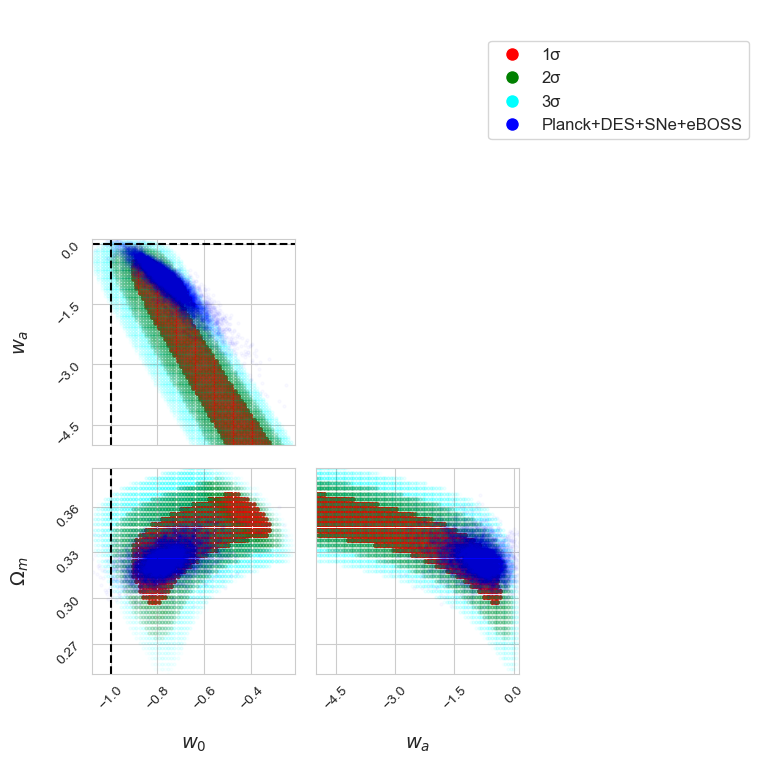

In [5]:
df['sigma_level'] = df['delta_chi2'].apply(assign_sigma)
df_filtered = df[df['sigma_level'] <= 3].copy()

parameters = ['w', 'wa', 'omega_m']
data = df_filtered[parameters].values

fig = corner.corner(
    data,
    labels=[r"$w_0$", r"$w_a$", r"$\Omega_m$"],  
    show_titles=True,
    title_fmt=".2f",
    plot_datapoints=False,
    plot_density=False,
    plot_contours=False,
    hist_kwargs={'color': 'black'},
    label_kwargs={'fontsize': 14}
)

axes = np.array(fig.axes).reshape((len(parameters), len(parameters)))

for i in range(len(parameters)):
    ax = axes[i, i]
    fig.delaxes(ax)

color_map = {1: 'red', 2: 'green', 3: 'cyan'}

for sigma in [1, 2, 3]:
    subset = df_filtered[df_filtered['sigma_level'] == sigma]
    color = color_map[sigma]
    alpha = {1: 1.0, 2: 0.05, 3: 0.02}[sigma]
    for i in range(len(parameters)):
        for j in range(i):
            ax = axes[i, j]
            ax.scatter(subset[parameters[j]], subset[parameters[i]], c=color, s=5, alpha=alpha)

truth_w = -1
truth_wa = 0

for i in range(len(parameters)):
    for j in range(i):
        ax = axes[i, j]
        if parameters[j] == 'w':
            ax.axvline(truth_w, color='black', linestyle='--', label='Truth w=-1')
        if parameters[i] == 'wa':
            ax.axhline(truth_wa, color='black', linestyle='--', label='Truth wa=0')

file_path_2 = 'fw0wacdm_planck+SN+eBOSS+3x2pt.txt'
data_sn_bao_cmb = pd.read_csv(file_path_2, sep='\s+', comment='#', header=None)

column_names_bao_cmb = [
    'omega_m', 'h0', 'omega_b', 'n_s', 'a_s', 'w', 'wa', 'mnu', 'tau',
    'shear_calibration_m1', 'shear_calibration_m2', 'shear_calibration_m3', 'shear_calibration_m4',
    'wl_photoz_bias_1', 'wl_photoz_bias_2', 'wl_photoz_bias_3', 'wl_photoz_bias_4',
    'lens_photoz_bias_1', 'lens_photoz_bias_2', 'lens_photoz_bias_3', 'lens_photoz_bias_4',
    'lens_photoz_width_1', 'lens_photoz_width_2', 'lens_photoz_width_3', 'lens_photoz_width_4',
    'bias_lens_b1', 'bias_lens_b2', 'bias_lens_b3', 'bias_lens_b4',
    'intrinsic_alignment_a1', 'intrinsic_alignment_a2', 'intrinsic_alignment_alpha1', 'intrinsic_alignment_alpha2',
    'intrinsic_alignment_bias_ta', 'prior', 'like', 'post', 'weight'
]
data_sn_bao_cmb.columns = column_names_bao_cmb

threshold_bao_cmb = data_sn_bao_cmb['weight'].max() * 1e-7
data_sn_bao_cmb_cleaned = data_sn_bao_cmb[data_sn_bao_cmb['weight'] > threshold_bao_cmb]

for i in range(len(parameters)):
    for j in range(i):
        ax = axes[i, j]
        x_planck = data_sn_bao_cmb_cleaned[parameters[j]].values
        y_planck = data_sn_bao_cmb_cleaned[parameters[i]].values
        ax.scatter(x_planck, y_planck, c='blue', s=5, alpha=0.02, label="Planck+DES+SNe+eBOSS")

fig.subplots_adjust(top=0.8, hspace=0.1, wspace=0.1)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='1σ', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='2σ', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='3σ', markerfacecolor='cyan', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Planck+DES+SNe+eBOSS', markerfacecolor='blue', markersize=10)
]

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 0.95), fontsize=12, frameon=True)

# Title
#fig.suptitle("w0wa cosmologies's BAO/CMB/SNe method in LCDM with results's $\Omega_m$\n"
  #           "SNe:0.353 ± 0.017 | BAO:0.295 ± 0.015 | CMB:0.315 ± 0.007\n"
  #           "Combined with Gaussian likelihood", fontsize=12, y=0.95)
plt.savefig("high_quality_plot.png", dpi=600)  

plt.tight_layout()
plt.show()